In [7]:
import sys; sys.path.append('..')
import re
import os 
import pickle

from collections import defaultdict
from tqdm import tqdm

from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from transformers import RobertaPreLayerNormForMaskedLM, AutoConfig

from hydra import compose, initialize
from hydra.core.config_store import ConfigStore
from src.utils.data import DatasetPreprocessor 
from src.config import BabyLMConfig
from src.tokenizer import load_tokenizer

### Data utils and helper functions

In [2]:
def base_collate_fn(_samples):
    joined_batch = defaultdict(list)
    for sample in _samples:
        for key, val in sample.items():
            joined_batch[key].append(torch.tensor(val))

    batch = {}

    for key, val in joined_batch.items():
        batch[key] = torch.stack(val)

    return batch

In [3]:
class AnisotropyComputation: 
    def __init__(
        self,
        num_layers=8,
        layer_name_template=re.compile("roberta_prelayernorm.encoder.layer.(\d+).output$")
    ):
        self.num_layers = num_layers
        self.layer_name_template = layer_name_template

        self.cosine_sims = defaultdict(list)
    
    def get_fw_hook(self, module_name):
        def _forward_hook(module, _, module_out):
            # compute the cosine similarity between two random vectors in module_output
            # between first and second element of batch
            indices = torch.randint(0, 128, (2,))
            selected_vectors = torch.stack([module_out[i, index] for i, index in enumerate(indices)])
            cosine_sim = F.cosine_similarity(selected_vectors[0].unsqueeze(0), selected_vectors[1].unsqueeze(0))

            self.cosine_sims[module_name].append(cosine_sim.item())
       
        return _forward_hook

    def setup_hooks(self, model):
        for name, module in model.named_modules():
            if self.layer_name_template.match(name):
                module.register_forward_hook(self.get_fw_hook(name))


In [4]:
repo_path = "/home/rd654/pos-merge/models/pos_merge-roberta_pre_layer_norm-model"
model_path = f"{repo_path}/lm_model"

In [63]:
#  NOTE: Setting up config in order to load in dataset 

cs = ConfigStore.instance()
cs.store(name="base_config", node=BabyLMConfig)
with initialize(version_base=None, config_path="../conf",):
    cfg = compose(
        config_name="config",
        overrides=[
            "experiment.name=baseline_clean",
            "experiment.group=anisotropy",
            "dataset=strict_small_gold",
            "experiment.offline_run=True",
        ])

dataset = load_dataset(
    cfg.dataset.name,
    cfg.dataset.subconfig,
)  # type: ignore
tokenizer = load_tokenizer(cfg)
data_preprocessor = DatasetPreprocessor(cfg, tokenizer)
eval_dataset = dataset["validation"].map(
    data_preprocessor,
    batched=True,
    num_proc=64,
    remove_columns=dataset["validation"].column_names,
    load_from_cache_file=False,
)

Map (num_proc=64): 100%|██████████| 322071/322071 [00:16<00:00, 19750.99 examples/s]


In [60]:
import subprocess 

def parse_git_logs(branch_name):
    # Prepare the git log command to get commit hashes and messages
    command = f"git -C {repo_path} log origin/{branch_name} --pretty=format:'%H %s'"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    
    # Check for errors
    if result.stderr:
        print("Error:", result.stderr)
        return {}
    
    # Split the output into lines
    lines = result.stdout.split('\n')
    
    # Create a dictionary to hold step number and commit hash
    commits_dict = {}
    
    # Iterate over each line and parse the commit hash and step
    for line in lines:
        parts = line.split(' ', 1)
        if len(parts) < 2:
            continue
        
        commit_hash = parts[0]
        commit_message = parts[1]
        
        # Look for the step number in the commit message
        if 'step' in commit_message:
            step_number = commit_message.split('step')[1].split()[0]  # Assume 'step' is followed by the step number
            commits_dict[step_number] = commit_hash
           
    return commits_dict

def checkout_branch(branch_name):
    command = f"git -C {repo_path} checkout origin/{branch_name}"
    subprocess.run(command, shell=True, capture_output=True, text=True)

def checkout_commit(commit_id):
    command = f"git -C {repo_path} checkout {commit_id}"
    subprocess.run(command, shell=True, capture_output=True, text=True)


In [121]:
output_file = "anisotropy_results.pkl"

branch_names = [
    "baseline_unclean",
    "tied_baseline_unclean_05_ls",
    "tied_baseline_unclean_08_ls",
    "tied_cosine_linear_02_10",
    "tied_cosine_linear_05_10", 
    "tied_cosine_linear_08_10",
    "tied_cosine_linear_05_05",
    "tied_cosine_linear_08_08",
]


def compute_initial_anisotropy():
    """
    Computes the anisotropy of a randomly initialized model
    """
    # This is just the commit id for step 200k of the tied baseline unclean model 
    # we'll use this commit to just load the model and then reinitialize the weights
    commit_id = "04ad593683da363ea197f40dccad465c8756175b"
    checkout_commit(commit_id)

    _model = RobertaPreLayerNormForMaskedLM.from_pretrained(model_path)
    _model.config._name_or_path = None # forcibly removing the name or path to require reinitialization
    model = RobertaPreLayerNormForMaskedLM(_model.config)

    model.cuda()
    model.eval()

    anisotropy_computation = AnisotropyComputation()
    anisotropy_computation.setup_hooks(model)

    _eval_dataset = eval_dataset.shuffle(seed=42)
    eval_dataloader = DataLoader(
        _eval_dataset,
        batch_size = 2,
        collate_fn=base_collate_fn,
    )

    for idx, _batch in tqdm(enumerate(eval_dataloader)):
        if idx > 1_000:
            break 

        batch  = {
            "input_ids": _batch["input_ids"].to("cuda"),
            "attention_mask": _batch["attention_mask"].to("cuda"),
        }
        model(**batch)
    
    return anisotropy_computation.cosine_sims


def compute_anisotropy_learning_dynamics():
    """ 
    Computes the anisotropy learning dynamics for the different branches and checkpoints
    """

    if os.path.exists(output_file):

        print("Loading in existing anisotropy results")
        with open(output_file, "rb") as f:
            anisotropy_results = pickle.load(f)
        
        return anisotropy_results

    anisotropy_results = dict()

    for branch_name in branch_names:
        print(f"Processing Batch Name: {branch_name}")

        checkout_branch(branch_name)
        branch_commit_steps = parse_git_logs(branch_name)

        anisotropy_results[branch_name] = dict()

        for checkpoint_step, commit_id in branch_commit_steps.items():

            print(f"Processing Checkpoint Step: {checkpoint_step}")
            checkout_commit(commit_id)

            model = RobertaPreLayerNormForMaskedLM.from_pretrained(model_path)
            model.cuda()
            model.eval()

            anisotropy_computation = AnisotropyComputation()
            anisotropy_computation.setup_hooks(model)

            _eval_dataset = eval_dataset.shuffle(seed=42)
            eval_dataloader = DataLoader(
                _eval_dataset,
                batch_size = 2,
                collate_fn=base_collate_fn,
            )

            for idx, _batch in tqdm(enumerate(eval_dataloader)):
                if idx > 1_000:
                    break 

                batch  = {
                    "input_ids": _batch["input_ids"].to("cuda"),
                    "attention_mask": _batch["attention_mask"].to("cuda"),
                }
                model(**batch)

            print(f"Branch: {branch_name}, Step: {checkpoint_step}")
            print("Cosine Similarity:")
            for layer_name, cosine_sims in anisotropy_computation.cosine_sims.items():
                print(f"{layer_name}: {sum(cosine_sims) / len(cosine_sims)}")
            print("\n\n")

            anisotropy_results[branch_name][checkpoint_step] = anisotropy_computation.cosine_sims

    # save out the results
    with open("anisotropy_results.pkl", "wb") as f:
        pickle.dump(anisotropy_results, f) 
    
    return anisotropy_results

In [120]:
_zero_step_anisotropy_results = compute_initial_anisotropy()
zero_step_anisotropy_results = dict()
for layer_name, cosine_sims in _zero_step_anisotropy_results.items():
    print(f"{layer_name}: {sum(cosine_sims) / len(cosine_sims)}")
    zero_step_anisotropy_results[layer_name] = sum(cosine_sims) / len(cosine_sims)

1001it [00:26, 37.33it/s]

roberta_prelayernorm.encoder.layer.0.output: 0.32088319116181785
roberta_prelayernorm.encoder.layer.1.output: 0.3231981401513149
roberta_prelayernorm.encoder.layer.2.output: 0.31585069957908457
roberta_prelayernorm.encoder.layer.3.output: 0.32982235347533917
roberta_prelayernorm.encoder.layer.4.output: 0.32903892745623936
roberta_prelayernorm.encoder.layer.5.output: 0.3269066082520204
roberta_prelayernorm.encoder.layer.6.output: 0.33077440157041443
roberta_prelayernorm.encoder.layer.7.output: 0.3284829876996897


In [12]:
anisotropy_results = compute_anisotropy_learning_dynamics()

Loading in existing anisotropy results


#### Anisotropy Learning Dynamics
Plotting out learning dynamics of different models over the course of training 

In [125]:
anisotropy_plotting = defaultdict(lambda: defaultdict(list))

for model_name, model_anisotropy_results in anisotropy_results.items():
    print(f"Model: {model_name}")

    # sort model_anisotropy_results by step
    model_anisotropy_results = dict(sorted(model_anisotropy_results.items(), key=lambda x: int(x[0])))

    for layer_name, initial_anisotropy in zero_step_anisotropy_results.items():
        anisotropy_plotting[model_name][layer_name].append(initial_anisotropy)

    for step, checkpoint_anisotropy_results in model_anisotropy_results.items():
        for layer_name, layer_cosines in checkpoint_anisotropy_results.items():
            anisotropy_plotting[model_name][layer_name].append(
                sum(layer_cosines) / len(layer_cosines)
            )

Model: baseline_unclean
Model: tied_baseline_unclean_05_ls
Model: tied_baseline_unclean_08_ls
Model: tied_cosine_linear_02_10
Model: tied_cosine_linear_05_10
Model: tied_cosine_linear_08_10
Model: tied_cosine_linear_05_05
Model: tied_cosine_linear_08_08


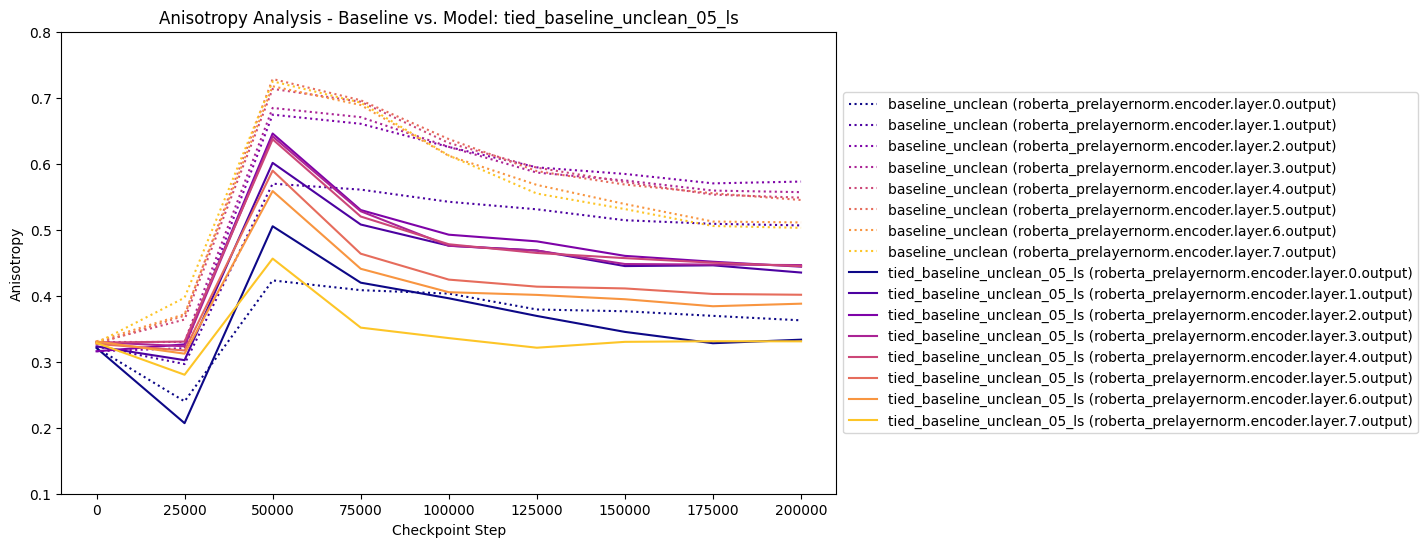

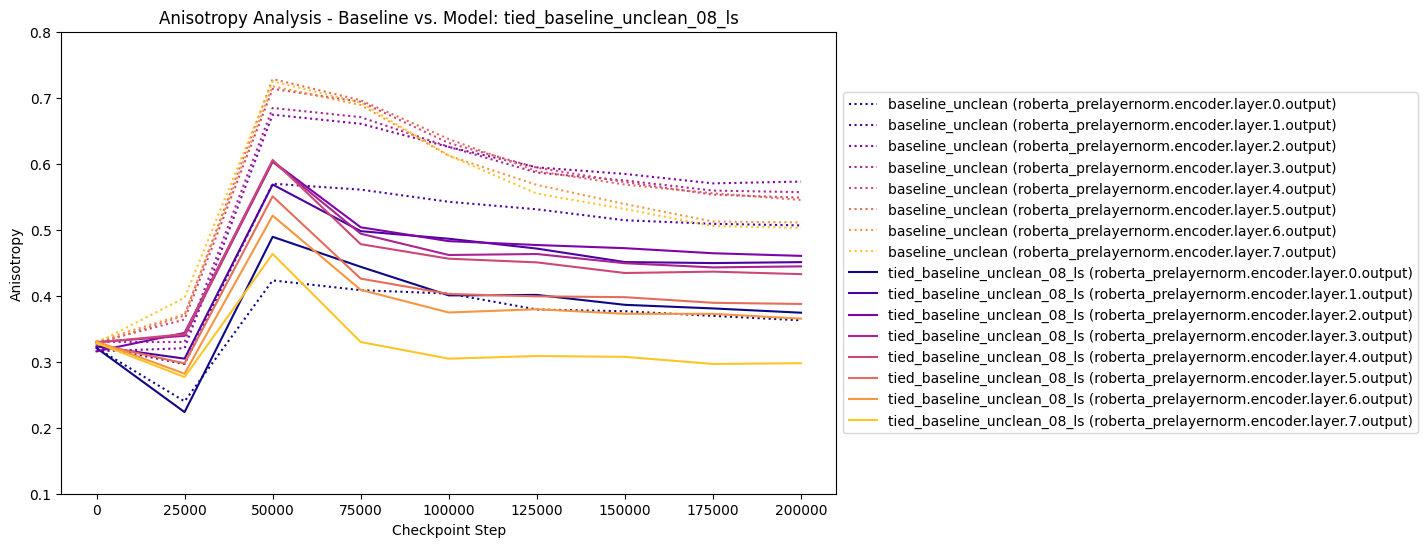

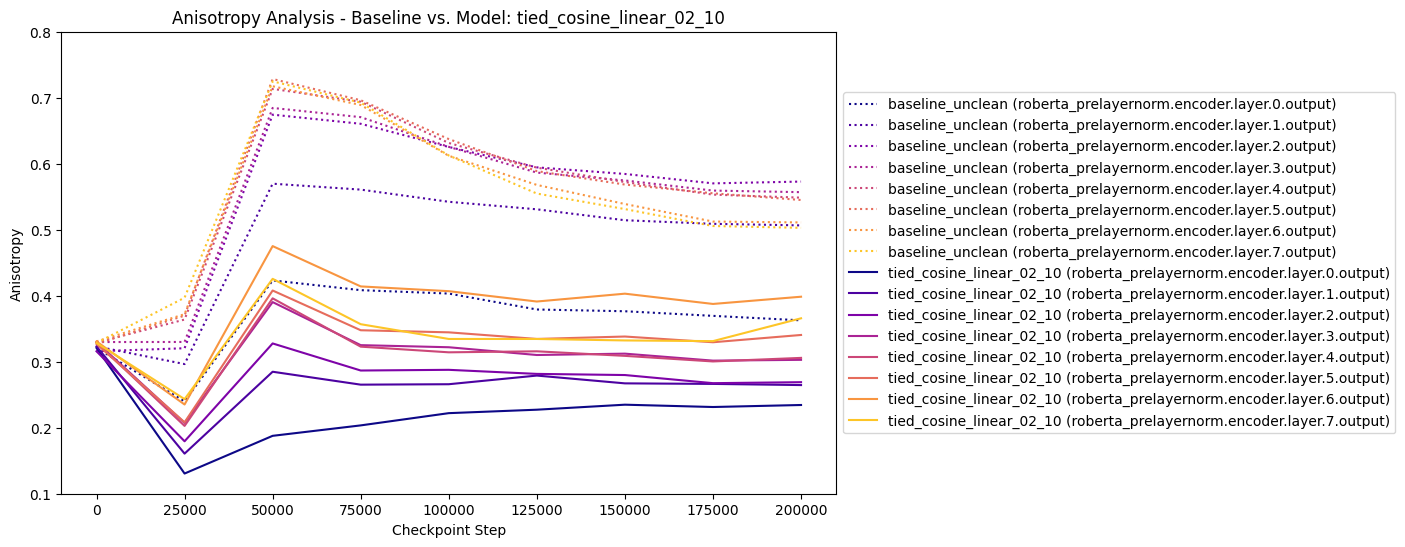

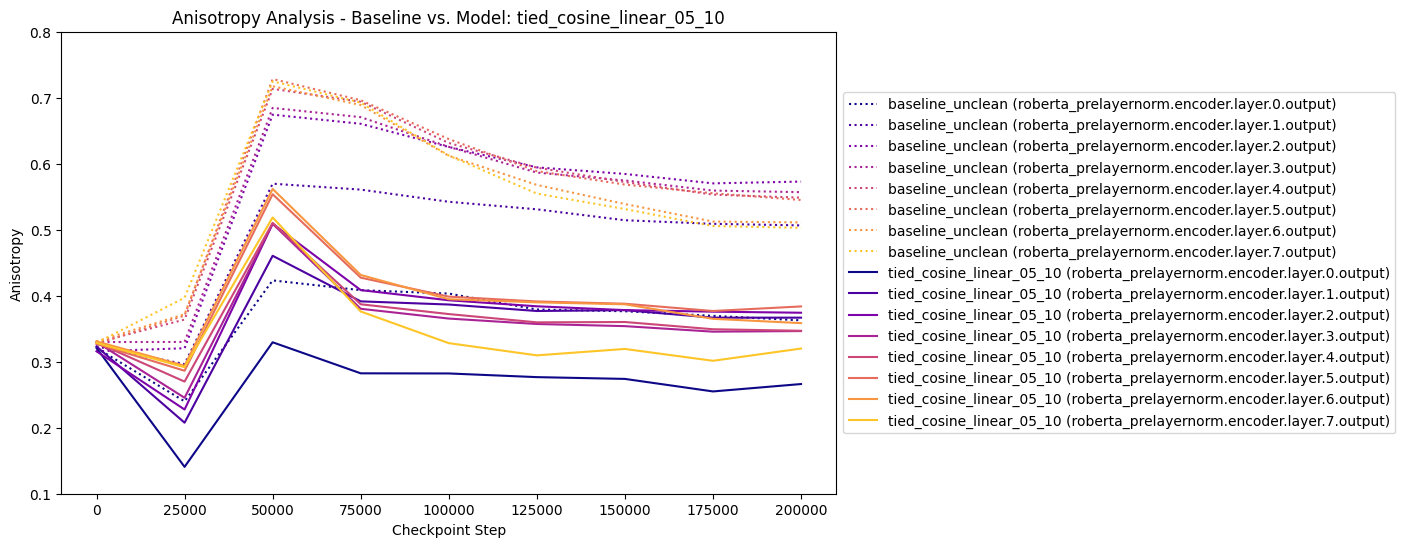

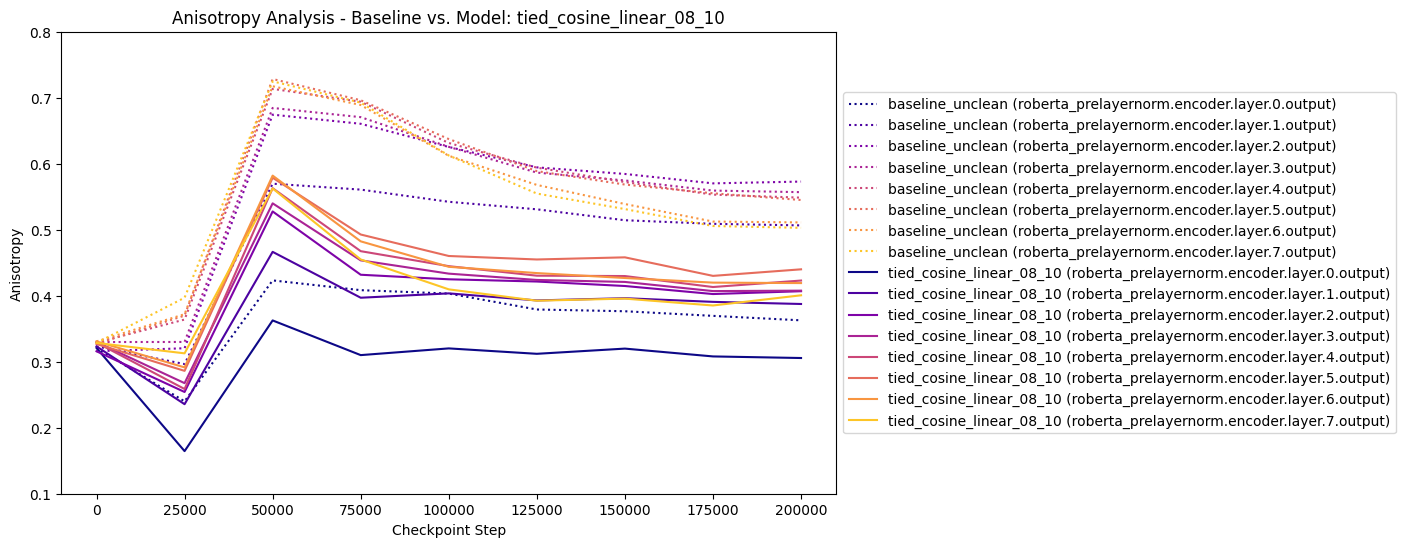

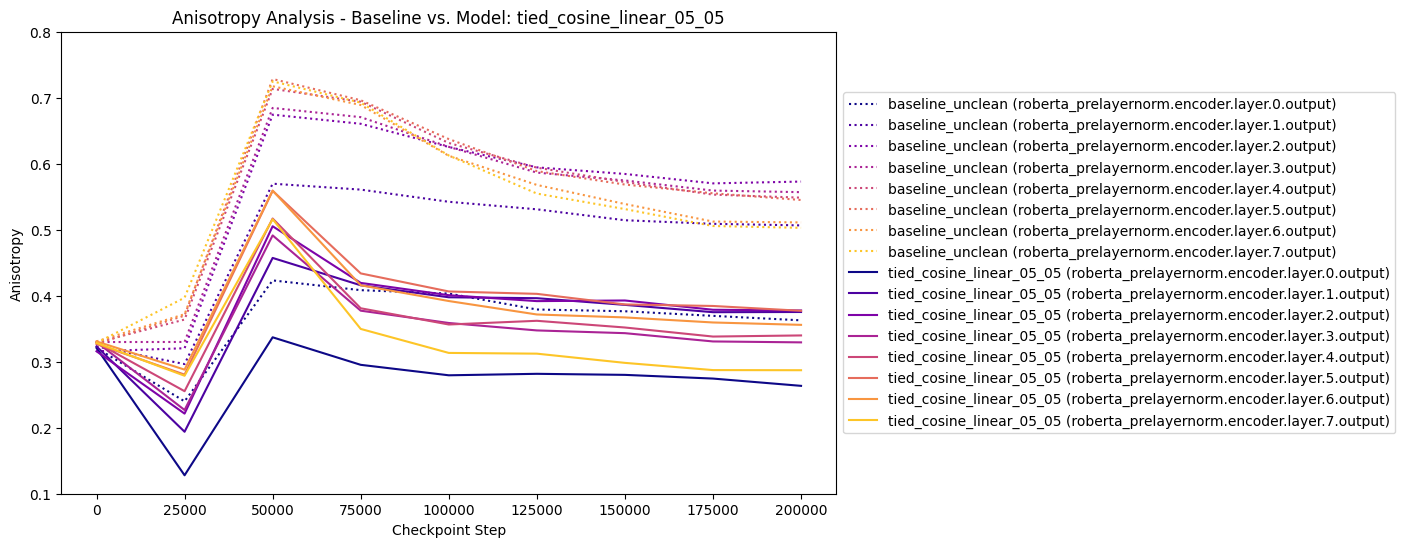

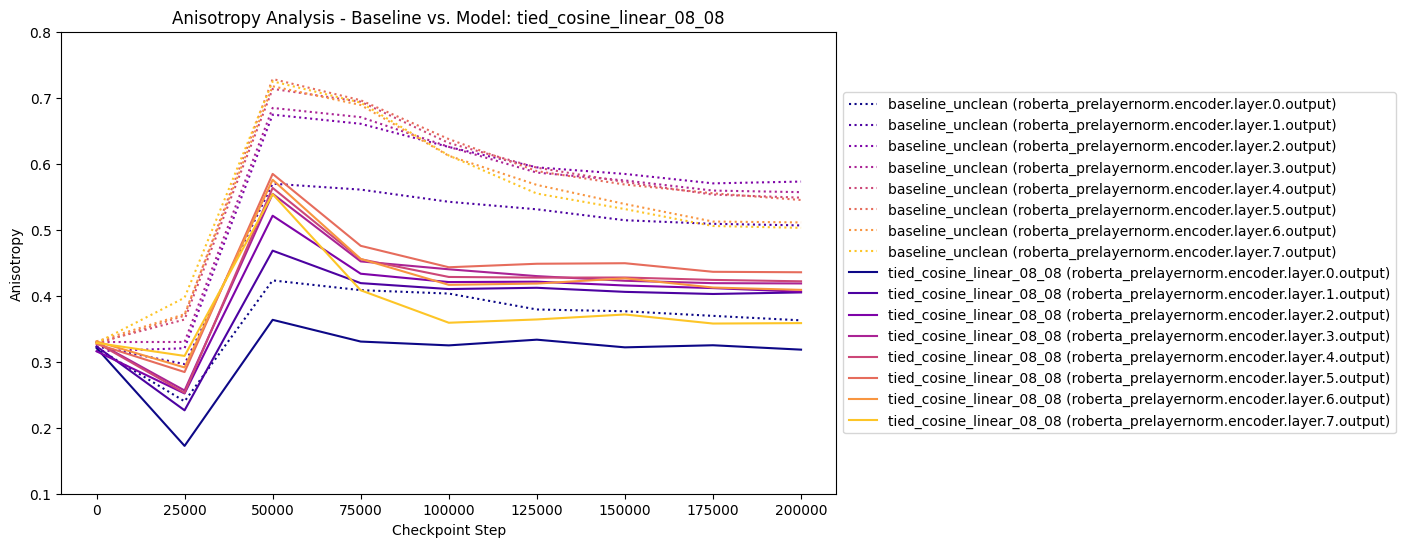

In [143]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
import numpy as np

# Define line styles for different model names
line_styles = {
    'baseline_unclean': ':',
    'tied_baseline_unclean_05_ls': '-',
    'tied_baseline_unclean_08_ls': '-',
    'tied_cosine_linear_02_10': '-',
    'tied_cosine_linear_05_10': '-',
    'tied_cosine_linear_08_10': '-',
    'tied_cosine_linear_05_05': '-',
    'tied_cosine_linear_08_08': '-',
}

checkpoint_steps = [i*25_000 for i in range(9)]

def adjust_color_heat(amount):
    # Use a heat color map
    cmap = plt.get_cmap('plasma')
    return cmap(amount)

# Baseline model to include in every plot
baseline_model = 'baseline_unclean'

# Specific models to compare
compare_models = [
    'tied_baseline_unclean_05_ls', 'tied_baseline_unclean_08_ls',
    'tied_cosine_linear_02_10', 'tied_cosine_linear_05_10', 
    'tied_cosine_linear_08_10', 'tied_cosine_linear_05_05', 
    'tied_cosine_linear_08_08'
]

# Loop over each specific model for individual plots
for model_name in compare_models:
    plt.figure(figsize=(10, 6))
    
    # Plot baseline_unclean in each comparison
    if baseline_model in anisotropy_plotting:
        for layer_index, (layer_name, layer_cosines) in enumerate(anisotropy_plotting[baseline_model].items()):
            normalized_index = layer_index / len(anisotropy_plotting[baseline_model])
            color = adjust_color_heat(normalized_index)
            plt.plot(checkpoint_steps, layer_cosines, label=f"{baseline_model} ({layer_name})", linestyle=line_styles[baseline_model], color=color)

    # Plot the specific model being compared
    if model_name in anisotropy_plotting:
        for layer_index, (layer_name, layer_cosines) in enumerate(anisotropy_plotting[model_name].items()):
            normalized_index = layer_index / len(anisotropy_plotting[model_name])
            color = adjust_color_heat(normalized_index)
            plt.plot(checkpoint_steps, layer_cosines, label=f"{model_name} ({layer_name})", linestyle=line_styles[model_name], color=color)

    # Adding labels and title
    plt.xlabel('Checkpoint Step')
    plt.ylabel('Anisotropy')
    plt.ylim(0.1,0.8)
    plt.title(f'Anisotropy Analysis - Baseline vs. Model: {model_name}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


Averaging over all of the layers so that for each model at each checkpoint we just compute the average anisotropy 

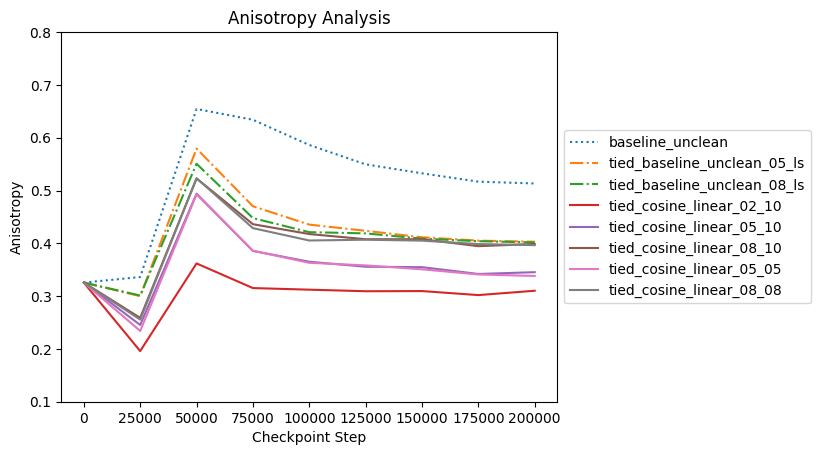

In [146]:
import matplotlib.pyplot as plt
import numpy as np


checkpoint_steps = [i*25_000 for i in range(9)]
num_layers = 8

line_styles = {
    'baseline_unclean': ':',
    'tied_baseline_unclean_05_ls': '-.',
    'tied_baseline_unclean_08_ls': '-.',
    'tied_cosine_linear_02_10': '-',
    'tied_cosine_linear_05_10': '-',
    'tied_cosine_linear_08_10': '-',
    'tied_cosine_linear_05_05': '-',
    'tied_cosine_linear_08_08': '-',
}

average_model_anisotropies = dict()

# Loop over each specific model for individual plots
for model_name, model_anisotropy in anisotropy_plotting.items():
 
    average_anisotropy = np.zeros(len(checkpoint_steps))
    # average over all fo the models 
    for idx, layer_cosines in enumerate(model_anisotropy.values()):
        average_anisotropy += np.array(layer_cosines)
    
    average_anisotropy /= num_layers

    average_model_anisotropies[model_name] = average_anisotropy

    # Plot the specific model being compared
    plt.plot(checkpoint_steps, average_anisotropy, label=f"{model_name}",linestyle=line_styles[model_name])

# Adding labels and title
plt.xlabel('Checkpoint Step')
plt.ylabel('Anisotropy')
plt.ylim(0.1,0.8)
plt.title(f'Anisotropy Analysis')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Correlation between anisotropy and frequency bias 

Reading in the associated learning dynamics for the frequency bias 

In [ ]:
# change name of baseline_unclean to tied_baseline_unclean
average_model_anisotropies['tied_baseline_unclean'] = average_model_anisotropies.pop('baseline_unclean')

In [162]:
# load in the bias_results.csv
import pandas as pd

bias_results = pd.read_csv("bias_results.csv")
model_biases = { 
    model_name: bias_results[f'{model_name} - eval/blimp_bias_total_increase'].tolist() for model_name in average_model_anisotropies.keys()
}


#### Linear and Polynomial Regression Analysis

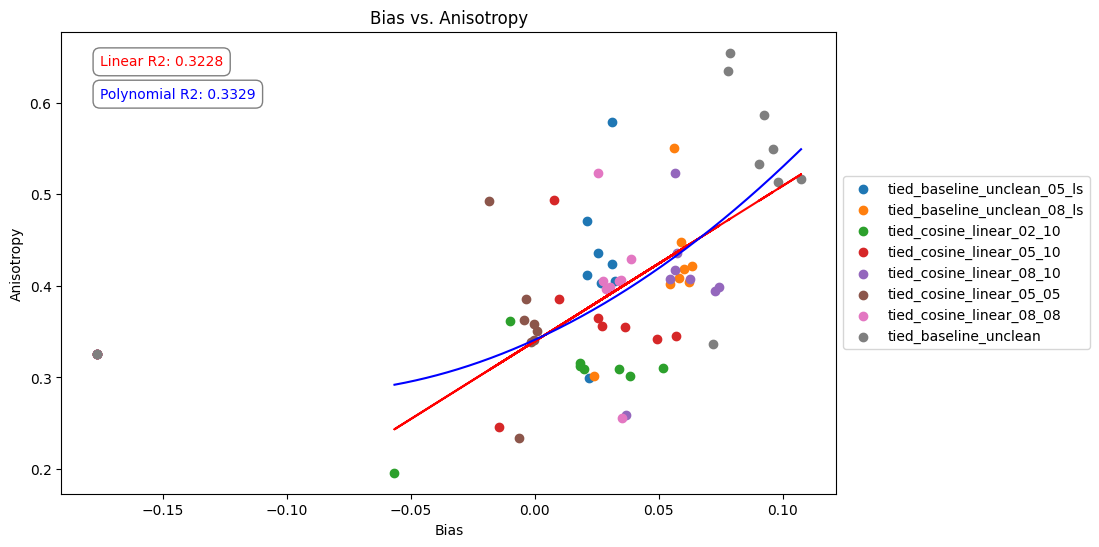

In [224]:
# plot the correlation between the bias and the anisotropy
plt.figure(figsize=(10, 6))

X_biases =  []
Y_anisotropy = []

for model_name in model_biases.keys():

    plt.scatter(model_biases[model_name], average_model_anisotropies[model_name], label=model_name)
    X_biases.extend(model_biases[model_name][1:])
    Y_anisotropy.extend(average_model_anisotropies[model_name][1:])

# compute the R2 value of X_biases and Y_anisotropy - show as red line on plot 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline


X_biases = np.array(X_biases).reshape(-1, 1)
Y_anisotropy = np.array(Y_anisotropy).reshape(-1, 1)


# LINEAR REGRESSION
reg = LinearRegression().fit(X_biases, Y_anisotropy)
linear_r2 = r2_score(Y_anisotropy, reg.predict(X_biases))
plt.plot(X_biases, reg.predict(X_biases), color='red',)

# POLYNOMIAL Regression
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X_biases, Y_anisotropy)
poly_r2 = r2_score(Y_anisotropy, poly_model.predict(X_biases))

X_grid = np.linspace(X_biases.min(), X_biases.max(), 500).reshape(-1, 1)
Y_pred = poly_model.predict(X_grid)

# Plot polynomial regression line
plt.plot(X_grid, Y_pred, color='blue',)


linear_r2_label = f"Linear R2: {linear_r2:.4f}"  # Replace `r2_score` with the actual R2 score value
plt.text(0.05, 0.95, linear_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color='red',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'), fontsize=10)
poly_r2_label = f"Polynomial R2: {poly_r2:.4f}"  # Replace `r2_score` with the actual R2 score value
plt.text(0.05, 0.88, poly_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color='blue',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'), fontsize=10)

plt.text(0.05, 0.88, poly_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'), fontsize=10)
plt.text(0.05, 0.88, poly_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'), fontsize=10)


# Adding labels and title
plt.xlabel('Bias')
plt.ylabel('Anisotropy')
plt.title('Bias vs. Anisotropy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Correlation Analysis

In [232]:
# correlate how the anisotropy changes with the bias
from scipy.stats import pearsonr, spearmanr, kendalltau

correlations = dict()
for model_name in model_biases.keys():
    print(f"Model Name: {model_name}")
    print(f"\t Pearson Correlation: {pearsonr(model_biases[model_name], average_model_anisotropies[model_name])}")
    print(f"\t Spearman Correlation: {spearmanr(model_biases[model_name], average_model_anisotropies[model_name])}")
    print(f"\t Kendall Correlation: {kendalltau(model_biases[model_name], average_model_anisotropies[model_name])}")

Model Name: tied_baseline_unclean_05_ls
	 Pearson Correlation: PearsonRResult(statistic=0.44775617232065856, pvalue=0.22682057097902902)
	 Spearman Correlation: SignificanceResult(statistic=0.3, pvalue=0.4328453267094823)
	 Kendall Correlation: SignificanceResult(statistic=0.2222222222222222, pvalue=0.47670855379188715)
Model Name: tied_baseline_unclean_08_ls
	 Pearson Correlation: PearsonRResult(statistic=0.5194915649982335, pvalue=0.15175555910101707)
	 Spearman Correlation: SignificanceResult(statistic=0.5666666666666667, pvalue=0.11163298761149111)
	 Kendall Correlation: SignificanceResult(statistic=0.3888888888888889, pvalue=0.18018077601410934)
Model Name: tied_cosine_linear_02_10
	 Pearson Correlation: PearsonRResult(statistic=0.10496607420488929, pvalue=0.7881184889207493)
	 Spearman Correlation: SignificanceResult(statistic=-0.3666666666666667, pvalue=0.33173980143301507)
	 Kendall Correlation: SignificanceResult(statistic=-0.2777777777777778, pvalue=0.35848765432098767)
Model

In [233]:
from scipy.stats import spearmanr, kendalltau

# Calculate pearson correlation coefficient
pearson_corr, _ = pearsonr(X_biases.flatten(), Y_anisotropy.flatten())

# Calculate Spearman's and Kendall's correlation coefficientsn
spearman_corr, _ = spearmanr(X_biases.flatten(), Y_anisotropy.flatten())
kendall_corr, _ = kendalltau(X_biases.flatten(), Y_anisotropy.flatten())

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall’s Tau: {kendall_corr}")

Pearson Correlation: 0.5681345874792221
Spearman Correlation: 0.5000457875457874
Kendall’s Tau: 0.3492063492063492
